### Import Libraries

In [1]:
"If it does not work use code below while running this notebook in this dir."
# import sys
# import os
# sys.path.append(os.path.abspath(os.getcwd()))

from mytorch import Tensor, Model
from mytorch import activation as active_func
from mytorch import loss as loss_func
from mytorch import optimizer as optim 
from mytorch import layer as nn
from mytorch.util import DataLoader
import numpy as np
from tqdm.auto import tqdm


from mytorch.util import flatten

import matplotlib.pyplot as plt

### Load MNIST

In [2]:
data_loader = DataLoader(train_addr='MNIST_light/MNIST/train', test_addr='MNIST_light/MNIST/test')
data_loader.load()
"you can see how data is loaded"
print(data_loader.getTrain()[0][0].shape)
print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...
(500, 28, 28)
(500,)


### Define and Create your Model

In [3]:
class MyModel(Model):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = active_func.sigmoid(self.fc1(x))
        x = active_func.relu(self.fc2(x))
        x = active_func.softmax(self.fc3(x))
        return x

model = MyModel()
print(model.summary())

fc1:  linear - total param: 100352 - in: 784, out: 128
fc2:  linear - total param: 8192 - in: 128, out: 64
fc3:  linear - total param: 640 - in: 64, out: 10
None


### Choose a Loss Function

In [4]:
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [5]:
optimizer = optim.SGD(model.parameters(), learning_rate=0.001)

### Training Model

In [6]:
# Define the number of epochs
EPOCH = 20

# Initialize lists to store training and test accuracies for each epoch
train_acc = []
test_acc = []

# Initialize variables to keep track of the best training and test accuracies
best_train_acc = 0.0
best_test_acc = 0.0

# Iterate over each epoch
for i in tqdm(range(EPOCH)):
    trn_corr = 0
    tst_corr = 0
    
    # Training loop
    for X_train, y_train in data_loader.getTrain():
        X_train = Tensor(X_train.data.reshape((-1, 784)) / 255.)
        y_pred_dev = model(X_train)
        optimizer.zero_grad()
        
        # Convert labels to one-hot encoding if necessary
        y_train_dev = y_train
        if y_train.data.ndim == 1:
            tmp_lbl = np.zeros_like(y_pred_dev.data, dtype=np.float64)
            for ind in range(tmp_lbl.shape[0]):
                tmp_lbl[ind][y_train.data[ind]] = 1
            y_train_dev = Tensor(tmp_lbl) 
        
        # Compute loss, backpropagate, and update weights
        loss = criterion(y_pred_dev, y_train_dev)
        loss.backward()
        optimizer.step()
        
        # Calculate the number of correct predictions
        predicted = np.argmax(y_pred_dev.data, 1)
        trn_corr += np.sum(np.equal(predicted, y_train.data))
    
    # Calculate training accuracy for the epoch
    acc = (trn_corr / 10000) * 100
    train_acc.append(acc)
    
    # Update the best training accuracy if the current epoch's accuracy is higher
    best_train_acc = acc if acc > best_train_acc else best_train_acc
    
    # Testing loop
    for X_test, y_test in data_loader.getTest():
        reshaped_data = Tensor(X_test.data.reshape((-1, 784)) / 255.)
        predicted_test = model.forward(reshaped_data)
        predicted_test = np.argmax(predicted_test.data, 1)
        tst_corr += np.sum(predicted_test == y_test.data)
    
    # Calculate test accuracy for the epoch
    acc2 = (tst_corr / 1000) * 100
    test_acc.append(acc2)
    
    # Update the best test accuracy if the current epoch's accuracy is higher
    best_test_acc = acc2 if acc2 > best_test_acc else best_test_acc
    


  0%|          | 0/20 [00:00<?, ?it/s]

### Evaluate Model Performance

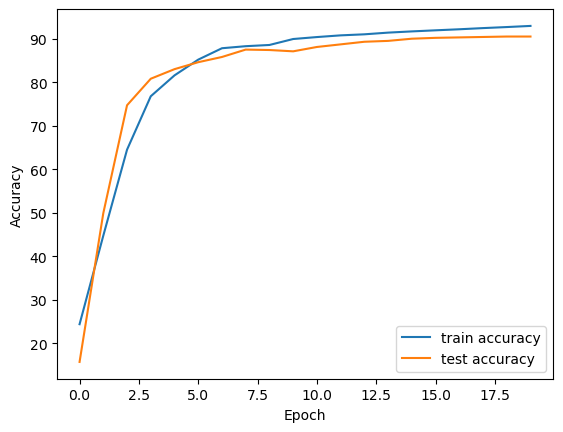


On train - best accuracy: 92.94, final accuracy: 92.94
On test - best accuracy: 90.50, final accuracy: 90.50


In [7]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))